# An Introduction to Convolutional Neural Nets
## Dr. Elliot Smith, CTO at Maxwell MRI
### es@mri.ai @smitec

# Overview

- An introduction to CNNs
- Tutorial: Writing your first CNN
- What's next in image processing

# An introduction to CNNs
## What is a Convolution?


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import convolve2d
%matplotlib inline

from scipy import misc
f = misc.face(gray=True)[::2, ::2]

kernel = np.array([[1, 1, 1], [0, 0, 0], [-1, -1, -1]])
a = convolve2d(f, kernel, mode='same')
b = convolve2d(f, kernel.T, mode='same')

![](https://upload.wikimedia.org/wikipedia/commons/9/97/Convolution_Animation_%28Boxcar%29.gif)

## Convolution in images

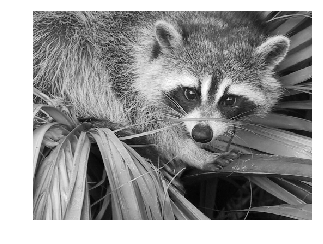

In [2]:
plt.figure(figsize=(5, 5))
plt.imshow(f, cmap='gray')
plt.axis('off')
plt.show()

In [3]:
print(kernel)

[[ 1  1  1]
 [ 0  0  0]
 [-1 -1 -1]]


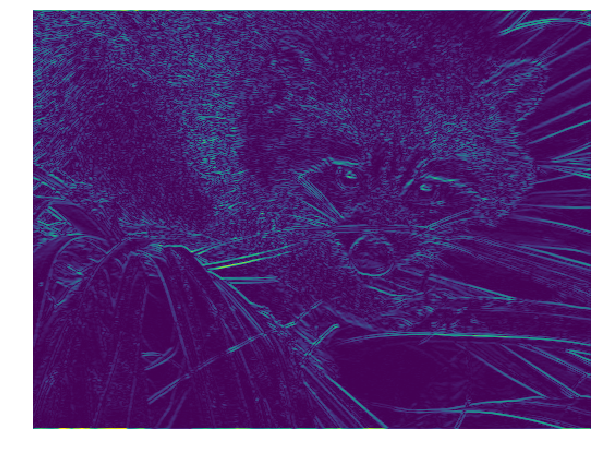

In [4]:
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(a))
plt.axis('off')
plt.show()

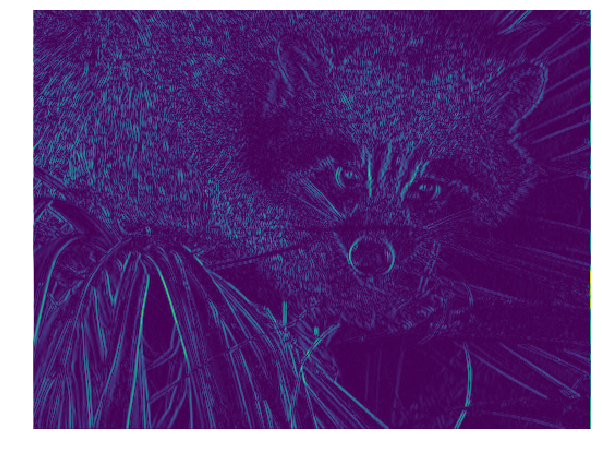

In [5]:
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(b))
plt.axis('off')
plt.show()

In [6]:
def edges():
    plt.figure(figsize=(20, 20))
    plt.subplot(2, 2, 1)
    plt.imshow(np.abs(a))
    plt.axis('off')
    plt.subplot(2, 2, 2)
    plt.imshow(np.abs(b))
    plt.axis('off')
    plt.subplot(2, 2, 3)
    plt.imshow(np.sqrt(a**2 + b**2))
    plt.axis('off')
    plt.tight_layout()
    plt.show() 

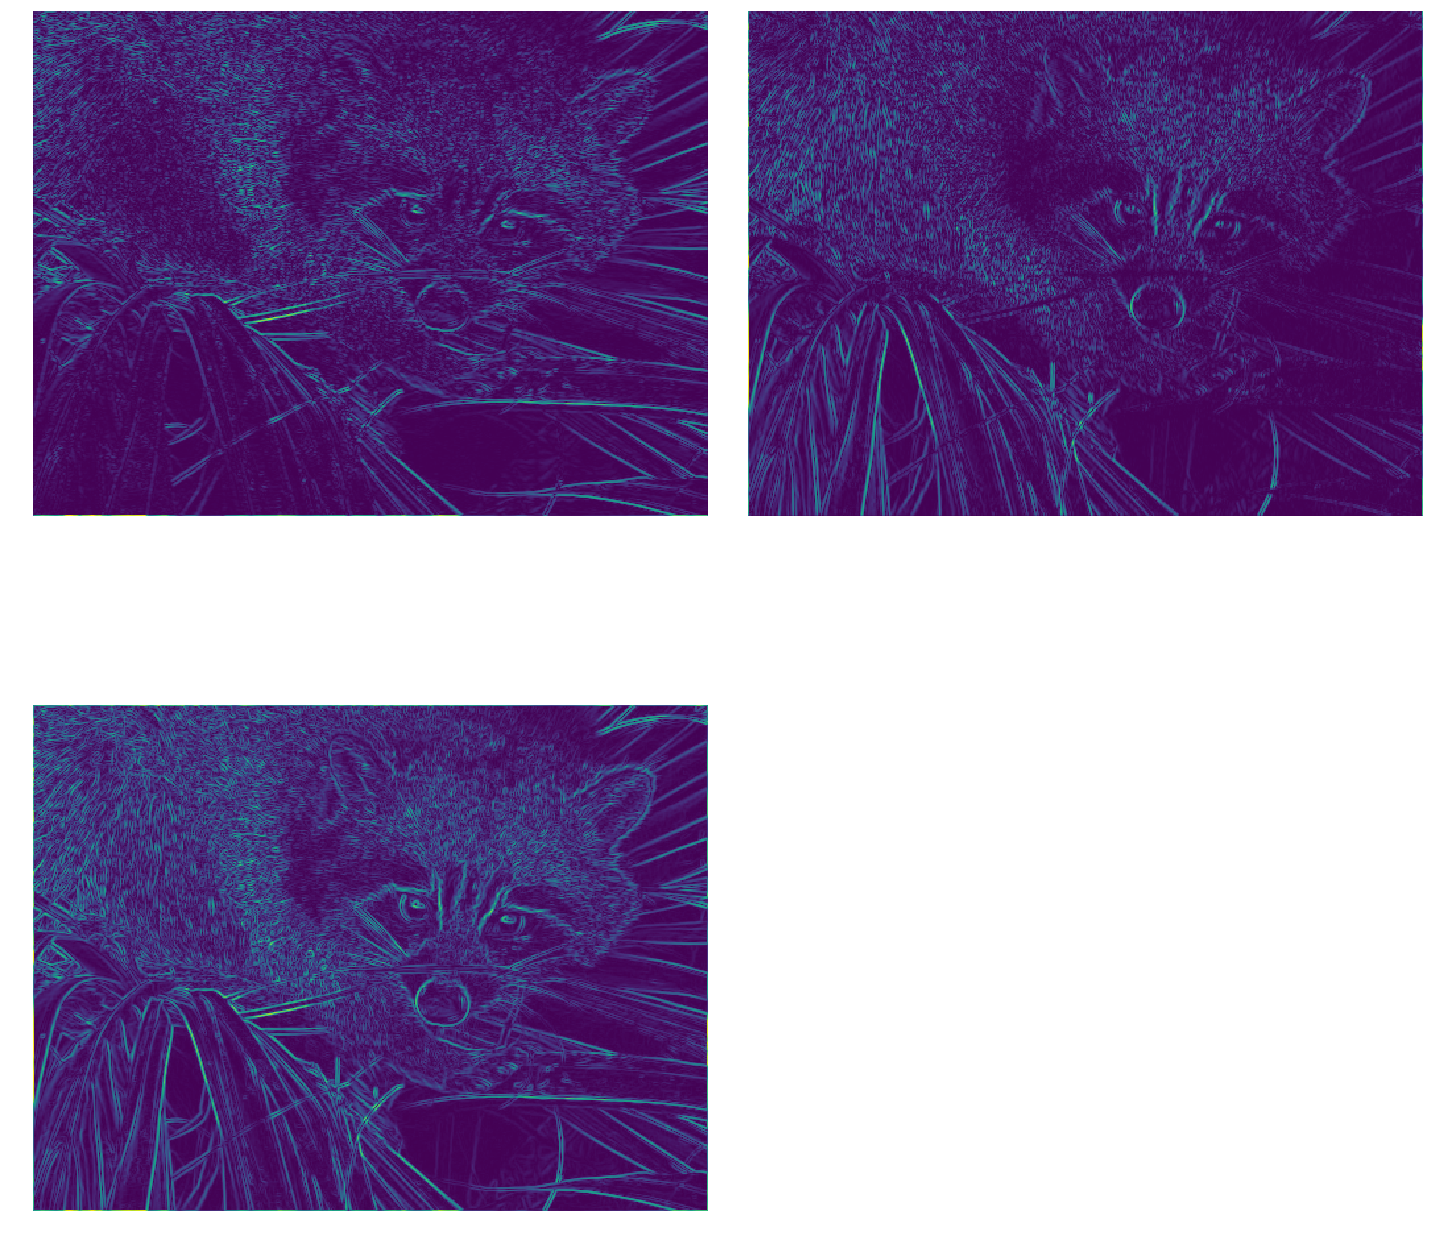

In [7]:
edges()

## How do we pick kernels?

### 0AD to 2015
Pick them by hand.

So called 'feature engineering'

## Today
We don't!

let the data pick kernels for you.

# Convolutional Neural Networks

![](https://raw.githubusercontent.com/iamaaditya/iamaaditya.github.io/master/images/conv_arithmetic/full_padding_no_strides_transposed.gif)

![](http://d3kbpzbmcynnmx.cloudfront.net/wp-content/uploads/2015/11/Screen-Shot-2015-11-07-at-7.26.20-AM.png)

# A convolution in Tensorflow

In [8]:
import tensorflow as tf

with tf.Session() as session:
    image = tf.placeholder(tf.float32, [1] + list(f.shape) + [1])
    kernel_tf = tf.constant(kernel[:, :, None, None], dtype=tf.float32)
    
    convolved = tf.nn.conv2d(image, kernel_tf, strides=[1, 1, 1, 1], padding='SAME')
    
    # Initialize the variables and run the result
    session.run(tf.global_variables_initializer())
    result = session.run(convolved, feed_dict={image: f[None, :, :, None]})

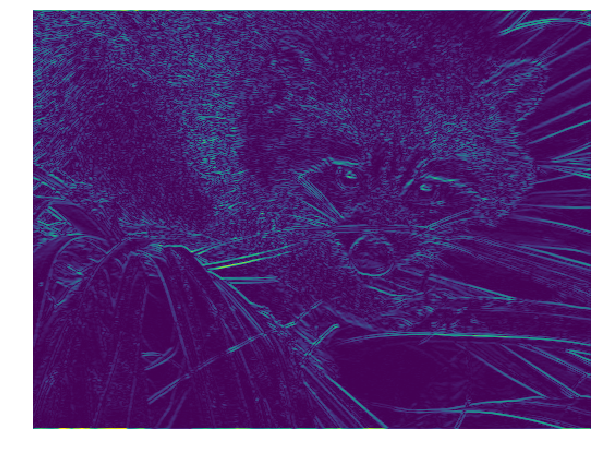

In [9]:
plt.figure(figsize=(10, 10))
plt.imshow(np.abs(result[0, :, :, 0]))
plt.axis('off')
plt.show()

## A closer look at the code

```python
with tf.Session() as session:
```

```python
    image = tf.placeholder(tf.float32, [1] + list(f.shape) + [1])
```

```python
    kernel_tf = tf.constant(kernel[:, :, None, None], dtype=tf.float32)
```

```python
    convolved = tf.nn.conv2d(image, kernel_tf, strides=[1, 1, 1, 1], padding='SAME')
```

```python
    session.run(tf.global_variables_initializer())
```

```python
    result = session.run(convolved, feed_dict={image: f[None, :, :, None]})
```

# Learning Convolutions

## MNIST Data

![](http://knowm.org/wp-content/uploads/Screen-Shot-2015-08-14-at-2.44.57-PM.png)

In [10]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [11]:
def weight_variable(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias_variable(shape):
    initial = tf.constant(0.1, shape=shape)
    return tf.Variable(initial)

In [12]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

In [13]:
session = tf.InteractiveSession()

x = tf.placeholder(tf.float32, shape=[None, 784])
y_ = tf.placeholder(tf.float32, shape=[None, 10])

In [14]:
# First Convolutional Layer
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(x, [-1,28,28,1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [15]:
# Second Convolutional Layer
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [16]:
# Fully Connected
W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])

h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])
h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [17]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [18]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y_conv))

train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv,1), tf.argmax(y_,1))

accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [19]:
session.run(tf.global_variables_initializer())
l = []
for i in range(2000):
    batch = mnist.train.next_batch(10)
    train_step.run(feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})
    l += [session.run(cross_entropy, feed_dict={x: batch[0], y_: batch[1], keep_prob: 0.5})]

print("test accuracy %g"%accuracy.eval(feed_dict={x: mnist.test.images, y_: mnist.test.labels, keep_prob: 1.0}))

test accuracy 0.9565


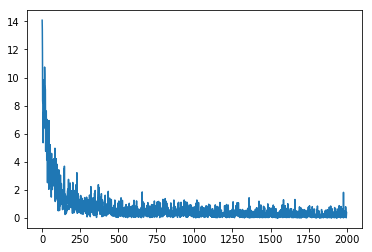

In [20]:
plt.plot(l)
plt.show()

# What's Next?

http://www.nature.com/nature/journal/v542/n7639/full/nature21056.html
![](http://www.nature.com/nature/journal/v542/n7639/carousel/nature21056-f2.jpg)

https://github.com/pdollar/coco/blob/master/PythonAPI/pycocoDemo.ipynb
![](http://farm5.staticflickr.com/4073/4913943958_7caa875cf3.jpg)
A large poodle takes part in a parade by riding a skateboard.

https://bamos.github.io/2016/08/09/deep-completion/
![](https://bamos.github.io/data/2016-08-09/face-arithmetic.png)

https://arxiv.org/pdf/1605.05396.pdf
![](https://raw.githubusercontent.com/reedscot/icml2016/master/images/cub_samples.jpg)

https://github.com/junyanz/CycleGAN
![](https://camo.githubusercontent.com/2fadde78dccf4d61f1294933c3e8083c07a303c7/68747470733a2f2f6a756e79616e7a2e6769746875622e696f2f4379636c6547414e2f696d616765732f6f626a656374732e6a7067)

https://github.com/kendricktan/drawlikebobross
![](https://camo.githubusercontent.com/7ef99b70814f63698811a41071c26bf182a82d3d/68747470733a2f2f692e696d6775722e636f6d2f3972645866644d2e706e67)